<a href="https://colab.research.google.com/github/pelinbalci/intent_classification_deprem/blob/master/intent_classification_tfifd_xgb_14k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## İçerik Sınıflandırma

**Data:** 10140 tutarlı etiketlenen tweet.

**Referans:** 
- https://www.kaggle.com/code/kobakhit/eda-and-multi-label-classification-for-arxiv [1]
- http://scikit.ml/_modules/skmultilearn/model_selection/iterative_stratification.html [2]

Fonksiyonlar ve pipeline'ın büyük kısmı [1]  nolu referanstan kopyalanmıştır. 
 
**Not:** Xgboost versiyon farklılığında şu error alınıyor: "predict_proba() got an unexpected keyword argument 'X'"   Hata almamak için version 1.3.3 yüklenmeli.

**İyileştirme noktaları:** 
- Xgboost için hyperparam tuning yapılmadı. Yalnızca scale_pos_weight denemeleri yapıldı. 
- IterativeStratification random selection yapıyor, random_state eklendiğinde
 hata veriyor.

 **Sonuç:**
 Farklı modellerden benzer sonuçlar alınmıştır. 

## Intent Classification

**Data:** 14562 consistent labeled tweet

**References:** 
- https://www.kaggle.com/code/kobakhit/eda-and-multi-label-classification-for-arxiv [1]
- http://scikit.ml/_modules/skmultilearn/model_selection/iterative_stratification.html [2]

Fucntions and most of the pipeline are copied from [1].
 
**Note:** There is an error when the Xgboost version is different "predict_proba() got an unexpected keyword argument 'X'"   Please install version 1.3.3

**Future works:** 
- Hyperparam tuning for Xgboost may help. Only scale_pos_weight has been tried.
- IterativeStratification splits the data randomly and it gives error when ranndom_state is added.

**Result:**
Similar results are obtained from different models.

### Import Libraries

In [1]:
!pip install scikit-multilearn
!pip install xgboost==1.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import json
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import IterativeStratification
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [3]:
# Helper Fucntions
# Label based accuracy
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list), acc_list

def predict_tags(X, models, labels=None):
    '''
    Predict tags for a given abstract.

    Args:
      - X (list): an iterable with text.
      - labels (pandas.Dataframe): label indicators for an abstract
    '''
    preds = []
    if type(X) is str:  # convert into iterable if string
        X = [X]

    # get prediction from each model
    for c in models.keys():
        preds.append(models[c].predict(X))

    # print original labels if given
    if labels is not None:
        assert len(X) == 1, 'Only one extract at a time.'
        predicted_tags = [k for k, v in zip(list(models.keys()), preds) if v[0] > 0]
        original_tags = list(labels.index[labels.map(lambda x: x > 0)])
        print('Original Tags: {}'.format(str(original_tags)))
        print("Predicted Tags: {}".format(str(predicted_tags)))

    return preds

### Read Data

In [4]:
# Read Data
data_10140 = 'full-10140-labeled-gigantic-bandicoot.jsonl'
data_14562 = 'full-14562-labeled-woodoo-chimpanzee.jsonl'
with open(data_14562, 'r') as json_file:
    json_list = list(json_file)

tutarli = {}
for i in range(len(json_list)):
    j_d = json.loads(json_list[i])
    tutarli[i] = j_d

In [5]:
len(tutarli)

14562

In [6]:
# Label distribution
tutarli_labels = []
for i in list(tutarli.keys()):
    tutarli_labels.append(tutarli[i]['label'])

# list of list to list
tutarli_labels_2 = [item for sub in tutarli_labels for item in sub]

# All Labels
etiketler = ["Arama Ekipmani", "Enkaz Kaldirma", "Isinma", "Elektrik Kaynagi", "Giysi", "Yemek", "Su",
             "Barınma", "Saglik", "Lojistik", "Tuvalet", "Alakasiz", "Cenaze"]

etiket_count = {}
for et in etiketler:
    etiket_count[et] = tutarli_labels_2.count(et)
print(etiket_count)

{'Arama Ekipmani': 833, 'Enkaz Kaldirma': 6436, 'Isinma': 1342, 'Elektrik Kaynagi': 499, 'Giysi': 1088, 'Yemek': 1616, 'Su': 437, 'Barınma': 3617, 'Saglik': 882, 'Lojistik': 280, 'Tuvalet': 67, 'Alakasiz': 2617, 'Cenaze': 24}


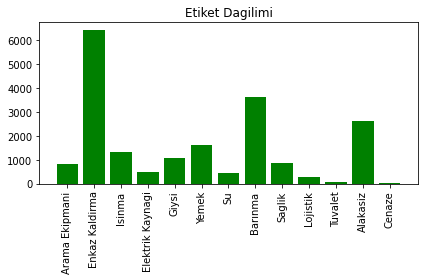

In [7]:
# Label distribution plot
fig = plt.figure()
plt.bar(etiket_count.keys(), etiket_count.values(), color='g')
plt.xticks(rotation=90)
plt.title('Etiket Dagilimi')
fig.tight_layout()
# plt.savefig('etiket_count.png')

### Preprocess
Alakasizlar çıkarılır.

Remove tag: "unrelated".


In [8]:
df = pd.DataFrame.from_dict(tutarli).T
mask = df.label.apply(lambda x: 'Alakasiz' not in x)
df = df[mask]
df = df.reset_index()
df['index'] = list(range(0, len(df)))
df.drop('index', axis=1, inplace=True)

print(len(df))

11945


In [9]:
mlb = MultiLabelBinarizer()
mlb_labels = mlb.fit_transform(df.label)

# Add labels to df
df_2 = pd.concat([df, pd.DataFrame(mlb_labels)], axis=1)
df_2.columns = ['image_url', 'label', 'label_confidence', 'labeler', 'label_creation_time'] + list(mlb.classes_)

In [10]:
# control categories
categories = df_2.columns[5:]
categories

Index(['Arama Ekipmani', 'Barınma', 'Cenaze', 'Elektrik Kaynagi',
       'Enkaz Kaldirma', 'Giysi', 'Isinma', 'Lojistik', 'Saglik', 'Su',
       'Tuvalet', 'Yemek'],
      dtype='object')

### Train - Test Split 

In [11]:
# RANDOM SELECTION
trainidx, testidx = list(IterativeStratification(n_splits=10, order=1).split(X=mlb_labels, y=mlb_labels))[0]
print(list(trainidx))
print(list(testidx))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 237, 238, 239, 240, 242, 

In [12]:
df_train_splitted = df_2.iloc[trainidx].reset_index(drop=True)
df_test_splitted = df_2.iloc[testidx].reset_index(drop=True)
print('train data: ', len(df_train_splitted), 'testid data: ', len(df_test_splitted))

X_train = df_train_splitted.image_url
X_test = df_test_splitted.image_url

train data:  10755 testid data:  1190


In [13]:
print(len(df_train_splitted.explode('label')))
print(len(df_test_splitted.explode('label')))

15392
1718


### Pipeline

In [14]:
# Define classifier 
classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=50, random_state=42, eval_metric='mlogloss'))

In [15]:
# for each category train the model and get accuracy, auc
models = {}
features = {}
preds = {}
for category in categories:
    # give pipelines unique names.
    SVC_pipeline = Pipeline([
        (f'tfidf_{category}', TfidfVectorizer()),
        (f'clf_{category}', OneVsRestClassifier(classifier, n_jobs=1)),
    ])
    print('... Processing {}'.format(category))

    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, df_train_splitted[category])
    models[category] = SVC_pipeline

    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    preds[category] = prediction
    accuracy = accuracy_score(df_test_splitted[category], prediction)

    # compute auc
    probas_ = SVC_pipeline.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(df_test_splitted[category], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Accuracy : {} . Area under the ROC curve : {}".format(round(accuracy, 4), round(roc_auc, 4)))
    print()

... Processing Arama Ekipmani
Accuracy : 0.9639 . Area under the ROC curve : 0.944

... Processing Barınma
Accuracy : 0.958 . Area under the ROC curve : 0.9875

... Processing Cenaze
Accuracy : 0.9983 . Area under the ROC curve : 0.7854

... Processing Elektrik Kaynagi
Accuracy : 0.9815 . Area under the ROC curve : 0.909

... Processing Enkaz Kaldirma
Accuracy : 0.9412 . Area under the ROC curve : 0.9897

... Processing Giysi
Accuracy : 0.9798 . Area under the ROC curve : 0.9837

... Processing Isinma
Accuracy : 0.9647 . Area under the ROC curve : 0.9691

... Processing Lojistik
Accuracy : 0.9832 . Area under the ROC curve : 0.9368

... Processing Saglik
Accuracy : 0.9639 . Area under the ROC curve : 0.9686

... Processing Su
Accuracy : 0.9866 . Area under the ROC curve : 0.9458

... Processing Tuvalet
Accuracy : 0.9992 . Area under the ROC curve : 0.9641

... Processing Yemek
Accuracy : 0.9756 . Area under the ROC curve : 0.9827



### Prediction

In [16]:
# predict tags for 20 image_urls
for i in range(0, 20):
    # print(df_test_splitted.image_url.iloc[i])
    print('Tweet number: ', i)
    predict_tags(df_test_splitted['image_url'].iloc[i], models, labels=df_test_splitted.iloc[i, 5:])
    print()

Tweet number:  0
Original Tags: ['Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  1
Original Tags: ['Barınma', 'Isinma', 'Yemek']
Predicted Tags: ['Barınma', 'Isinma', 'Lojistik', 'Yemek']

Tweet number:  2
Original Tags: ['Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  3
Original Tags: ['Barınma', 'Giysi', 'Su', 'Yemek']
Predicted Tags: ['Barınma', 'Giysi', 'Su']

Tweet number:  4
Original Tags: ['Arama Ekipmani', 'Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  5
Original Tags: ['Arama Ekipmani', 'Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  6
Original Tags: ['Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  7
Original Tags: ['Arama Ekipmani', 'Enkaz Kaldirma']
Predicted Tags: ['Enkaz Kaldirma']

Tweet number:  8
Original Tags: ['Barınma', 'Elektrik Kaynagi', 'Saglik']
Predicted Tags: ['Elektrik Kaynagi']

Tweet number:  9
Original Tags: ['Arama Ekipmani', 'Enkaz Kaldirma']
Predicte

In [17]:
# get all predictions
y_pred = np.array(predict_tags(df_test_splitted.image_url, models)).T
# get true labels in the same order
y_true = df_test_splitted[list(models.keys())].to_numpy()
print(y_pred.shape)

(1190, 12)


In [18]:
# Scores
hamming_loss_v = hamming_loss(y_true, y_pred) # fraction of labels assgined incorrectly. the lower the better
acc_ = accuracy_score(y_true, y_pred)
mean_score, list_score = hamming_score(y_true, y_pred)

print('hamming_loss: ', hamming_loss_v)
print('Accuracy: ', acc_)
print('mean scroe: ', mean_score)

hamming_loss:  0.02535014005602241
Accuracy:  0.7798319327731092
mean scroe:  0.8761424569827931


In [19]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=list(categories)))

                  precision    recall  f1-score   support

  Arama Ekipmani       0.86      0.58      0.69        83
         Barınma       0.93      0.93      0.93       362
          Cenaze       0.00      0.00      0.00         2
Elektrik Kaynagi       0.80      0.73      0.77        49
  Enkaz Kaldirma       0.91      0.99      0.95       643
           Giysi       0.94      0.85      0.89       118
          Isinma       0.88      0.79      0.83       134
        Lojistik       0.70      0.50      0.58        28
          Saglik       0.87      0.60      0.71        88
              Su       0.89      0.72      0.79        43
         Tuvalet       1.00      0.86      0.92         7
           Yemek       0.94      0.88      0.91       161

       micro avg       0.91      0.88      0.89      1718
       macro avg       0.81      0.70      0.75      1718
    weighted avg       0.90      0.88      0.89      1718
     samples avg       0.92      0.91      0.90      1718



### Control

In [20]:
mask = df_test_splitted.label.apply(lambda x: 'Giysi' in x)
print('Giysi:', len(df_test_splitted[mask]))

mask = df_test_splitted.label.apply(lambda x: 'Cenaze' in x)
print('Cenaze:', len(df_test_splitted[mask]))

mask = df_test_splitted.label.apply(lambda x: 'Arama Ekipmani' in x)
print('Arama Ekipmani:', len(df_test_splitted[mask]))

mask = df_test_splitted.label.apply(lambda x: 'Barınma' in x)
print('Barınma:', len(df_test_splitted[mask]))

Giysi: 118
Cenaze: 2
Arama Ekipmani: 83
Barınma: 362


## Test Different Models

In [21]:
def model_results(categories, classifier, X_train, df_train_splitted, df_test_splitted):
  # for each category train the model and get accuracy, auc
  models = {}
  features = {}
  preds = {}
  for category in categories:
      # give pipelines unique names.
      SVC_pipeline = Pipeline([
          (f'tfidf_{category}', TfidfVectorizer()),
          (f'clf_{category}', OneVsRestClassifier(classifier, n_jobs=1)),
      ])
      print('... Processing {}'.format(category))

      # train the model using X_dtm & y
      SVC_pipeline.fit(X_train, df_train_splitted[category])
      models[category] = SVC_pipeline

  # get all predictions
  y_pred = np.array(predict_tags(df_test_splitted.image_url, models)).T
  # get true labels in the same order
  y_true = df_test_splitted[list(models.keys())].to_numpy()

  # Classification Report
  print(classification_report(y_true, y_pred, target_names=list(categories)))


In [22]:
# classifier = CalibratedClassifierCV(LinearSVC())
# classifier = CalibratedClassifierCV(DecisionTreeClassifier(max_depth=10))
# classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=50, random_state=42))
# classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=75, learning_rate=0.02, gamma=3, max_depth=8))
# classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=100))
# classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=25))

In [26]:
classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=1.5, random_state=42, eval_metric='mlogloss'))
model_results(categories, classifier, X_train, df_train_splitted, df_test_splitted)

... Processing Arama Ekipmani
... Processing Barınma
... Processing Cenaze
... Processing Elektrik Kaynagi
... Processing Enkaz Kaldirma
... Processing Giysi
... Processing Isinma
... Processing Lojistik
... Processing Saglik
... Processing Su
... Processing Tuvalet
... Processing Yemek
                  precision    recall  f1-score   support

  Arama Ekipmani       0.92      0.53      0.67        83
         Barınma       0.97      0.91      0.94       362
          Cenaze       0.00      0.00      0.00         2
Elektrik Kaynagi       0.85      0.69      0.76        49
  Enkaz Kaldirma       0.95      0.99      0.97       643
           Giysi       0.94      0.76      0.84       118
          Isinma       0.94      0.77      0.84       134
        Lojistik       0.92      0.43      0.59        28
          Saglik       0.93      0.57      0.70        88
              Su       0.93      0.65      0.77        43
         Tuvalet       1.00      0.71      0.83         7
           Yeme

In [24]:
classifier = CalibratedClassifierCV(LinearSVC())
model_results(categories, classifier, X_train, df_train_splitted, df_test_splitted)

... Processing Arama Ekipmani
... Processing Barınma
... Processing Cenaze
... Processing Elektrik Kaynagi
... Processing Enkaz Kaldirma
... Processing Giysi
... Processing Isinma
... Processing Lojistik
... Processing Saglik
... Processing Su
... Processing Tuvalet
... Processing Yemek
                  precision    recall  f1-score   support

  Arama Ekipmani       0.86      0.58      0.69        83
         Barınma       0.94      0.91      0.93       362
          Cenaze       0.00      0.00      0.00         2
Elektrik Kaynagi       0.80      0.73      0.77        49
  Enkaz Kaldirma       0.96      0.98      0.97       643
           Giysi       0.93      0.83      0.88       118
          Isinma       0.89      0.79      0.84       134
        Lojistik       0.71      0.61      0.65        28
          Saglik       0.92      0.76      0.83        88
              Su       0.84      0.72      0.77        43
         Tuvalet       1.00      0.86      0.92         7
           Yeme

In [25]:
classifier = CalibratedClassifierCV(xgb.XGBClassifier(scale_pos_weight=100, random_state=42, eval_metric='mlogloss'))
model_results(categories, classifier, X_train, df_train_splitted, df_test_splitted)

... Processing Arama Ekipmani
... Processing Barınma
... Processing Cenaze
... Processing Elektrik Kaynagi
... Processing Enkaz Kaldirma
... Processing Giysi
... Processing Isinma
... Processing Lojistik
... Processing Saglik
... Processing Su
... Processing Tuvalet
... Processing Yemek
                  precision    recall  f1-score   support

  Arama Ekipmani       0.87      0.63      0.73        83
         Barınma       0.91      0.93      0.92       362
          Cenaze       0.00      0.00      0.00         2
Elektrik Kaynagi       0.84      0.76      0.80        49
  Enkaz Kaldirma       0.90      0.99      0.94       643
           Giysi       0.92      0.82      0.87       118
          Isinma       0.91      0.75      0.82       134
        Lojistik       0.78      0.50      0.61        28
          Saglik       0.85      0.53      0.66        88
              Su       0.88      0.70      0.78        43
         Tuvalet       1.00      0.86      0.92         7
           Yeme